In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchinfo
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Paths for dataset files
base_path = '/kaggle/input/food-101/food-101/food-101'
meta_path = os.path.join(base_path, 'meta')
images_path = os.path.join(base_path, 'images')
classes_path = os.path.join(meta_path, 'classes.txt')
train_path = os.path.join(meta_path, 'train.txt')
test_path = os.path.join(meta_path, 'test.txt')

In [5]:
# LabelEncoder class
class LabelEncoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def encode(self, label):
        return self.labels.get(label, self.labels['other'])

    def decode(self, idx):
        return list(self.labels.keys())[idx]

In [6]:
# Directory to check
directory_to_check = '/kaggle/input/food-101/food-101'

# List contents of the directory
print("Listing contents of directory:", directory_to_check)
try:
    print(os.listdir(directory_to_check))
except FileNotFoundError as e:
    print("Error:", e)

Listing contents of directory: /kaggle/input/food-101/food-101
['__MACOSX', 'food-101']


In [7]:
# Function to load classes
def load_classes(file_path):
    with open(file_path, 'r') as file:
        classes = file.read().splitlines()
    return classes[:20] + ['other']

classes_21 = load_classes(classes_path)
encoder_21 = LabelEncoder(classes_21)

In [8]:
# Function to prepare dataframe
def prep_df(path: str, encoder: LabelEncoder) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    full_path = [os.path.join(images_path, img + ".jpg") for img in array]
    labels, ids = zip(*[img.split('/') for img in array])
    labels = [encoder.encode(label) for label in labels]
    return pd.DataFrame({'label': labels, 'path': full_path})

train_imgs = prep_df(train_path, encoder_21)
test_imgs = prep_df(test_path, encoder_21)

In [9]:
# Data Augmentation and Dataset Definition
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = Food21(train_imgs, train_transforms)
test_dataset = Food21(test_imgs, test_transforms)

In [10]:
# DataLoaders
train_loader = DataLoader(Food21(train_imgs, train_transforms), batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(Food21(test_imgs, test_transforms), batch_size=64, shuffle=False, num_workers=4)


In [11]:
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()

        self.fc = nn.Linear(101, 21)
    
    def forward(self, x):
        return self.fc(x)

In [12]:
weights = models.DenseNet201_Weights.IMAGENET1K_V1
head = Head()

model = models.densenet201(weights = weights)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 87.5MB/s]


In [13]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [14]:
# Downloading updated pretrained weights 
import requests as reqs

url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"  
r = reqs.get(url, allow_redirects=True)

open("./food_classifier.pt", "wb").write(r.content)

81841763

In [15]:
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

<All keys matched successfully>

In [16]:
model = nn.DataParallel(nn.Sequential(model, head))

torchinfo.summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [1, 21]                   --
├─Sequential: 1-1                                  [1, 21]                   20,165,699
├─Sequential: 1-2                                  --                        --
│    └─DenseNet: 2-1                               [1, 101]                  20,163,557
│    └─DenseNet: 2-2                               --                        --
│    │    └─Sequential: 3-1                        [1, 1920, 7, 7]           (18,092,928)
│    │    └─Sequential: 3-2                        --                        (18,092,928)
│    │    └─Sequential: 3-3                        [1, 101]                  2,070,629
│    │    └─Sequential: 3-4                        --                        2,070,629
│    └─Head: 2-3                                   [1, 21]                   2,142
│    └─Head: 2-4                                   --         

In [17]:
#hyper parameters
num_epochs = 10
lr = 1e-3

In [18]:
# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

In [19]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [21]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          history: dict()):
  
  # Create empty results dictionairy if the provided dictionairy is empty
  if history == None:
      history = {
          "train_loss": [],
          "train_acc": [],
          "test_loss": [],
          "test_acc": [],
          'best train acc': (0, 0),
          "best_model": dict()
      }

  # Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
      print('Epoch {}/{}'.format(epoch + 1, epochs))

      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          f"\n\n=============================\n"
      )

      # Update results dictionary
      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["test_loss"].append(test_loss)
      history["test_acc"].append(test_acc)
      if test_acc > max(history["test_acc"]):
          history["best_model"] = model.state_dict()

      if test_acc > 0.96:
         break

  # Return the filled results at the end of the epochs
  return model, history

In [22]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device, history=None)

Epoch 1/10
--> Training Progress


100%|██████████| 395/395 [01:50<00:00,  3.56it/s]]


Epoch: 1 | train_loss: 0.5273 | train_acc: 0.8651 | test_loss: 0.2030 | test_acc: 0.9368


Epoch 2/10
--> Training Progress


100%|██████████| 1184/1184 [06:32<00:00,  3.02it/s]


--> Testing Progress


100%|██████████| 395/395 [01:50<00:00,  3.58it/s]


Epoch: 2 | train_loss: 0.4154 | train_acc: 0.8850 | test_loss: 0.1779 | test_acc: 0.9436


Epoch 3/10
--> Training Progress


 99%|█████████▉| 1176/1184 [06:32<00:02,  3.09it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 395/395 [01:50<00:00,  3.56it/s]


Epoch: 4 | train_loss: 0.3920 | train_acc: 0.8900 | test_loss: 0.1798 | test_acc: 0.9438


Epoch 5/10
--> Training Progress


100%|██████████| 1184/1184 [06:42<00:00,  2.94it/s]


--> Testing Progress


100%|██████████| 395/395 [01:56<00:00,  3.39it/s]


Epoch: 5 | train_loss: 0.3866 | train_acc: 0.8940 | test_loss: 0.1561 | test_acc: 0.9504


Epoch 6/10
--> Training Progress


100%|██████████| 1184/1184 [06:42<00:00,  2.94it/s]


--> Testing Progress


100%|██████████| 395/395 [01:50<00:00,  3.58it/s]


Epoch: 6 | train_loss: 0.3779 | train_acc: 0.8944 | test_loss: 0.1746 | test_acc: 0.9458


Epoch 7/10
--> Training Progress


100%|██████████| 1184/1184 [06:38<00:00,  2.97it/s]


--> Testing Progress


100%|██████████| 395/395 [01:50<00:00,  3.59it/s]


Epoch: 7 | train_loss: 0.3752 | train_acc: 0.8947 | test_loss: 0.1418 | test_acc: 0.9559


Epoch 8/10
--> Training Progress


100%|██████████| 1184/1184 [06:34<00:00,  3.00it/s]


--> Testing Progress


100%|██████████| 395/395 [01:51<00:00,  3.54it/s]


Epoch: 8 | train_loss: 0.3677 | train_acc: 0.8956 | test_loss: 0.1547 | test_acc: 0.9507


Epoch 9/10
--> Training Progress


100%|██████████| 1184/1184 [06:39<00:00,  2.96it/s]


--> Testing Progress


100%|██████████| 395/395 [01:50<00:00,  3.56it/s]


Epoch: 9 | train_loss: 0.3646 | train_acc: 0.8971 | test_loss: 0.1731 | test_acc: 0.9458


Epoch 10/10
--> Training Progress


100%|██████████| 1184/1184 [06:39<00:00,  2.96it/s]


--> Testing Progress


100%|██████████| 395/395 [01:51<00:00,  3.55it/s]

Epoch: 10 | train_loss: 0.3626 | train_acc: 0.8981 | test_loss: 0.1687 | test_acc: 0.9464




In [24]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=1, device=device, history=history)

Epoch 1/1
--> Training Progress


100%|██████████| 1184/1184 [06:31<00:00,  3.02it/s]


--> Testing Progress


100%|██████████| 395/395 [01:50<00:00,  3.58it/s]

Epoch: 1 | train_loss: 0.3592 | train_acc: 0.8991 | test_loss: 0.1492 | test_acc: 0.9527




In [25]:
def plot_history(history):

    loss = history['train_loss']
    accuracy = history['train_acc']
    val_loss = history['test_loss']
    val_accuracy = history['test_acc']
    x = range(len(loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
      plt.plot(x, val_accuracy, label='Validation acc', color='#48cae4', linewidth=2)
    plt.plot(history['best train acc'][0],
             history['best train acc'][1],
             label='Best train acc', markersize=7, color='black')
    plt.title('Accuracy')
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
      plt.plot(x, val_loss, label='Validation loss', color='#48cae4', linewidth=2)
    plt.title('Loss')
    plt.grid(True)
    plt.legend()

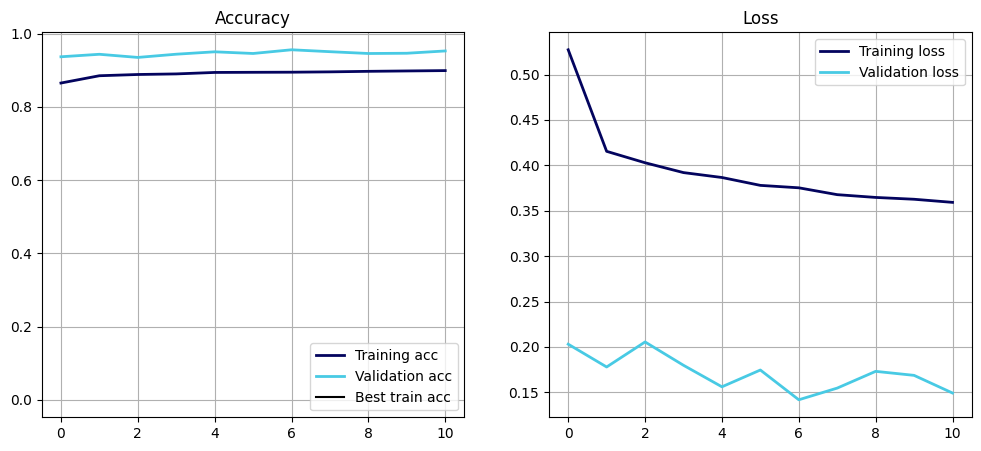

In [26]:
plot_history(history)

In [27]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [28]:
evaluate(model,test_loader)

100%|██████████| 395/395 [01:50<00:00,  3.57it/s]

95.26732673267327


In [29]:
torch.save(model.state_dict(), "./model.pth")